<span style="font-size:250%">Analysis of results of iteration #2</span>

This is the notebook for the results of the second iteration of repository analysis. The documentation for this run can be found in the [RepoAnalysis](./RepoAnalysis.ipynb) notebook. In the second iteration, an approach that is based on commit-deltas (from git log) has been used which greatly increased performance and aimed at increasing data density (as no join over ght.raw_patches is necessary anymore).

As this run was meant as a way to compare the different analysis methods (thus running on the same data set as the first one), the evaluation is shorter. We expect to see similar effects as in [the first result set](Results_Iteration#1.ipynb), but the better data density might also lead to new results.

The notebook is structured as follows: Before the data is evaluated, an [overview](#General-overview-over-results) over it is gained and it is [joined with and aggregated on](Prepare-for-analysis) author information. The data is then [visualized](#Visualization) with boxplots in order to manually compare it to the last run. Finally, [a Mann–Whitney U test](#Statistical-Testing) is applied to check for significance between the experiment groups and comre those results to the previous run.

In [1]:
%load_ext autoreload
%aimport dbUtils

In [2]:
import matplotlib.pyplot as pyplot

In [3]:
tableName = 'lb_results2'

## General overview over results

First let's get an overview over the structure of the result data before we get into the evaluation.

### How many tuples are there and how do they look like?

There are 530k tuples. Additions and deletions are now embedded into the result table. This table actually is the counterpart for the `lb_deltas` table of result set 1, because it already includes delta information instead of absolute numbers. To compare, the other table includes 292k tuples. This however, cannot yet be fully compared, as the other table also eliminated fork duplicates.

In [10]:
dbUtils.runQuery('''
    SELECT *
    FROM crm20.'''+tableName+'''
''', mute=True)

Time used: 2.827662706375122


,sha,parent,timestamp,repo_id,additions,deletions,loc,cloc,file_count,num_methods,num_lambdas,num_comment_lines,num_reflection,num_snakes,total_indent
0,d721ef5e04f8dd01e06af16d6e991dd6c7e9e922,b905107dab06e985464cf31d7c7c52bc4d31ecce,1421418236,6128043,0,0,0,0,0,0,0,0,0,0,0
1,a4e0db847d762956fda983187b962f82b2a6ae9a,45adb8de177bacf302d1e4eed0e2cfffa0651937,1418751191,6128043,76,0,76,34,1,3,0,1,2,0,44
2,45adb8de177bacf302d1e4eed0e2cfffa0651937,a28984af8ceadadcf15e38e92d9055a8830ae6d6,1408534004,6128043,0,0,0,0,0,0,0,0,0,0,0
3,cd592e0aa4effc205550c839055e3ab8d74aa3df,5f479f709ff6d511799949d0f05e02edb234a56c,1408533995,6128043,0,0,0,0,0,0,0,0,0,0,0
4,5f479f709ff6d511799949d0f05e02edb234a56c,750c56c138716c9cf37613b09b4013ac046807ef,1408533857,6128043,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530334,4dab5ec84ea69ff8db6699527c67971440753c1d,983d36fd357a75e7693057f76ceeda16932d57e9,1418149334,13395535,122,1,121,87,5,13,0,0,0,8,86
530335,983d36fd357a75e7693057f76ceeda16932d57e9,65c847e0d2be48038f3483fa2718f27d5ba7740c,1417386728,13395535,0,0,0,0,0,0,0,0,0,0,0
530336,65c847e0d2be48038f3483fa2718f27d5ba7740c,f0605d5b9c3e830c35619625de69437bd67a42a3,1417030624,13395535,1,1,0,0,0,0,0,0,0,0,0
530337,f0605d5b9c3e830c35619625de69437bd67a42a3,96e54c833612e1f52b056cbbcb2f85d9e732fbc3,1416338568,13395535,0,0,0,0,0,0,0,0,0,0,0


### How many tuples can we attribute to experiment authors?

There are 27k tuples that we can attribute to experiment authors (and thus use for evaluation). This is a lot more than the 16k from iteration #1, which shows that the methodological migrations was a success.

In [18]:
dbUtils.runQuery('''
    SELECT DISTINCT lb_results2.sha
    FROM crm20.lb_results2, ght.commits
    WHERE lb_results2.sha = commits.sha
    AND author_id IN (SELECT author_id FROM crm20.lb_experimentusers)
''')

Time used: 3.4830398559570312


,sha
0,000087d0ec3a5150cd62626532a55d2f9b01ac44
1,00011c69673a28cdca68e586f6696bec815fac0e
2,0003fef9ab586a6879bed31eed2b17d70e5040c9
3,00052a0cacf3a5cde7e00cc92307684422ebd090
4,000535f8fe003dcef57e064237809008365269f8
...,...
27613,fff9e88f19d76939dc18613ea15658f1bcddbad9
27614,fffd4cf210007056d0c690404a143a7ad65fc1c0
27615,fffdd5712ac1a4a03ae91e18b546d3a5ea22b384
27616,fffdf1de02630b7b0199876ac5ba01710c753412


## Prepare for analysis

### Add author information and filter for experiment authors

Again, author information is joined in to attribute the commit changes to developers. This time, only the experiment users are taken. Note the `DISTINCT` which, together with the removal of the `repoId` column, eliminates duplicates originating from forks.

In [21]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_experimentset2;
    
    CREATE MATERIALIZED VIEW crm20.lb_experimentset2 AS (
        SELECT DISTINCT lb_results2.sha, lb_results2.timestamp, author_id, additions, deletions, additions + deletions AS changes, loc, cloc, file_count, num_methods, num_lambdas, num_comment_lines, num_reflection, num_snakes, total_indent
        FROM crm20.lb_results2, ght.commits
        WHERE lb_results2.sha = commits.sha
        AND author_id IN (SELECT author_id FROM crm20.lb_experimentusers)
    );
    
    SELECT * FROM crm20.lb_experimentset2
''')

Time used: 3.6220011711120605


,sha,timestamp,author_id,additions,deletions,changes,loc,cloc,file_count,num_methods,num_lambdas,num_comment_lines,num_reflection,num_snakes,total_indent
0,000087d0ec3a5150cd62626532a55d2f9b01ac44,1433252442,2192544,281,0,281,281,203,2,12,0,0,1,16,316
1,00011c69673a28cdca68e586f6696bec815fac0e,1488388630,32841082,0,0,0,0,0,0,0,0,0,0,0,0
2,0003fef9ab586a6879bed31eed2b17d70e5040c9,1423257092,911011,787,341,1128,446,356,8,101,0,1,1,3,35
3,00052a0cacf3a5cde7e00cc92307684422ebd090,1343833520,512799,385,326,711,59,0,0,0,0,0,0,0,0
4,000535f8fe003dcef57e064237809008365269f8,1438023546,61025,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27613,fff9e88f19d76939dc18613ea15658f1bcddbad9,1474157313,911011,0,0,0,0,0,0,0,0,0,0,0,0
27614,fffd4cf210007056d0c690404a143a7ad65fc1c0,1500429726,89727,0,0,0,0,0,0,0,0,0,0,0,0
27615,fffdd5712ac1a4a03ae91e18b546d3a5ea22b384,1479404863,31888379,32,17,49,15,15,0,1,0,-17,0,1,80
27616,fffdf1de02630b7b0199876ac5ba01710c753412,1363035194,34131,23,4,27,19,18,0,0,0,4,0,0,35


### Create averages for authors

As this analysis run will not use the lifecylce approach, averages for each author can safely be calculated. This allows to reflect over the overall code quality of each author and to compare authors of the two groups.  

In [25]:
dbUtils.runQuery('''
    DROP VIEW IF EXISTS crm20.lb_authoravgs2;
    CREATE VIEW crm20.lb_authoravgs2 AS (
        SELECT
            author_id,
            AVG(CAST(loc AS DECIMAL)) AS loc,
            AVG(CAST(cloc AS DECIMAL)) AS cloc,
            AVG(CAST(file_count AS DECIMAL)) AS filecount,
            AVG(CAST(num_methods AS DECIMAL)/changes) AS methods,
            AVG(CAST(num_lambdas AS DECIMAL)/changes) AS lambdas,
            AVG(CAST(num_comment_lines AS DECIMAL)/changes) AS commentlines,
            AVG(CAST(num_reflection AS DECIMAL)/changes) AS reflection,
            AVG(CAST(num_snakes AS DECIMAL)/changes) AS snakes,
            AVG(CAST(total_indent AS DECIMAL)/changes) AS indent
        FROM crm20.lb_experimentset2
        WHERE changes > 0
        AND changes < 1000
        GROUP BY author_id
    );
    SELECT * FROM crm20.lb_authoravgs2
''', mute=True)

Time used: 0.038674116134643555


,author_id,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,32388630,33.065217,28.130435,0.391304,0.013284,0.000174,0.022456,-0.000001,0.004914,0.264950
1,11128019,52.518519,51.148148,0.888889,0.029190,0.000000,-0.011043,0.000000,0.003590,0.399675
2,4648147,-59.000000,-43.400000,-1.600000,-0.020199,0.000000,-0.000755,-0.001440,-0.003425,-0.018397
3,5683227,338.000000,281.000000,4.000000,0.052747,0.000000,0.124863,0.000000,0.015150,2.287897
4,5773514,183.571429,159.500000,0.857143,0.010893,0.000851,0.017985,0.000097,0.003445,1.089008
...,...,...,...,...,...,...,...,...,...,...
165,2104969,51.915663,42.560241,0.680723,0.025413,0.006035,0.000587,0.002804,0.007571,0.504876
166,34131,85.121813,60.067989,0.909348,0.025413,0.000022,0.075840,0.001657,0.033800,0.649125
167,40932899,273.000000,203.750000,4.000000,0.062500,0.000000,0.038508,0.000000,0.020381,0.926963
168,10133167,3.000000,3.000000,0.000000,0.000000,0.000000,0.006289,0.000000,0.000000,0.044025


# Visualization

Again to visualize effects, boxplots have been chosen. This is very similar to [Results_Iteration#1](Results_Iteration#1.ipynb). The following queries extract the respective data sets for both experiment groups

In [26]:
boxDataPolyglot = dbUtils.runQuery('''
    SELECT *
    FROM crm20.lb_authoravgs2
    WHERE author_id IN (SELECT author_id FROM crm20.lb_polyglots)
''', mute=True)
display(boxDataPolyglot)

Time used: 0.03542947769165039


,author_id,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,32388630,33.065217,28.130435,0.391304,0.013284,0.000174,0.022456,-0.000001,0.004914,0.264950
1,5773514,183.571429,159.500000,0.857143,0.010893,0.000851,0.017985,0.000097,0.003445,1.089008
2,1871511,31.416667,27.833333,0.166667,0.007226,0.000000,0.053341,0.000000,0.016890,1.121245
3,3766069,39.189189,35.445946,0.472973,0.016054,0.000000,0.046977,-0.000191,0.002390,0.682632
4,10280180,106.166667,96.333333,0.500000,0.020586,0.000000,0.042827,0.000000,0.017579,0.934093
...,...,...,...,...,...,...,...,...,...,...
83,933950,19.675676,19.351351,0.081081,0.010594,0.000000,0.006372,0.000028,0.009838,0.455133
84,32603443,51.090909,45.696970,0.393939,0.024657,0.003118,0.018778,0.001580,0.000000,0.760338
85,382849,68.153439,39.682540,1.238095,0.035706,0.000204,0.003751,0.009541,0.002008,0.678013
86,32841082,142.652174,120.913043,1.521739,0.035066,-0.000349,0.174493,0.000000,0.023267,0.907254


In [27]:
boxDataControlGroup = dbUtils.runQuery('''
    SELECT *
    FROM crm20.lb_authoravgs2
    WHERE author_id IN (SELECT author_id FROM crm20.lb_controlgroup)
''', mute=True)
display(boxDataControlGroup)

Time used: 0.034987449645996094


,author_id,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,11128019,52.518519,51.148148,0.888889,0.029190,0.000000,-0.011043,0.000000,0.003590,0.399675
1,4648147,-59.000000,-43.400000,-1.600000,-0.020199,0.000000,-0.000755,-0.001440,-0.003425,-0.018397
2,5683227,338.000000,281.000000,4.000000,0.052747,0.000000,0.124863,0.000000,0.015150,2.287897
3,4263043,253.571429,235.000000,1.000000,0.059057,0.000000,0.045479,0.003905,0.026579,2.063136
4,1347191,73.897436,61.282051,0.871795,0.021135,0.007953,0.069218,0.001757,0.008853,0.730582
...,...,...,...,...,...,...,...,...,...,...
77,1577259,28.782609,25.942029,0.159420,0.007683,0.000000,-0.017804,0.000000,0.016797,0.315197
78,34131,85.121813,60.067989,0.909348,0.025413,0.000022,0.075840,0.001657,0.033800,0.649125
79,40932899,273.000000,203.750000,4.000000,0.062500,0.000000,0.038508,0.000000,0.020381,0.926963
80,10133167,3.000000,3.000000,0.000000,0.000000,0.000000,0.006289,0.000000,0.000000,0.044025


When plotting the data and putting the plots side by side, the results look very similar: Value ranges increased a bit, which is expectable with a bigger dataset, but there were no big notable changes.

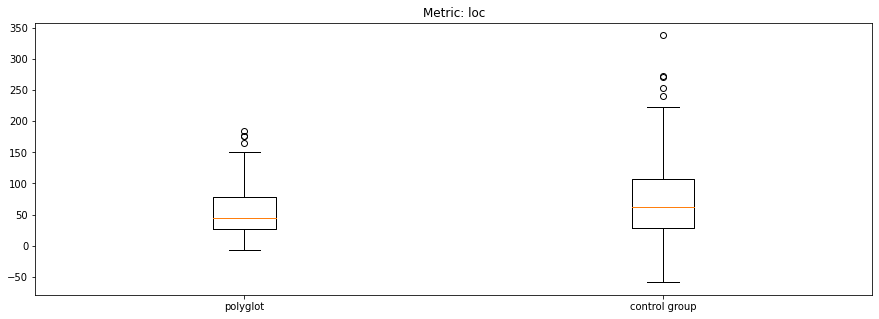

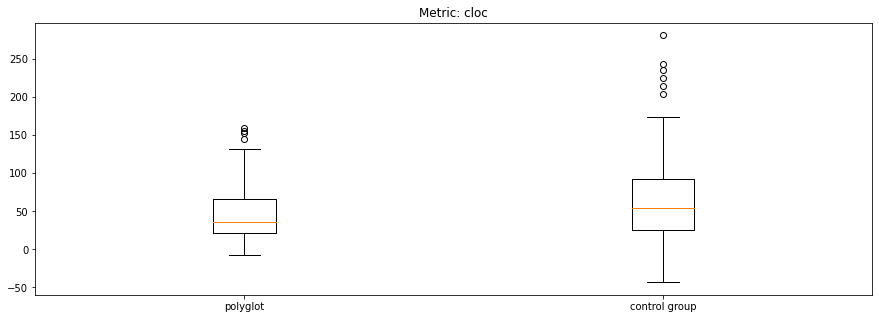

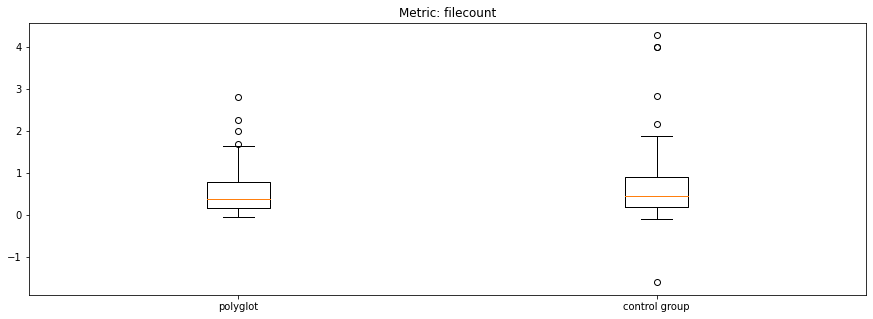

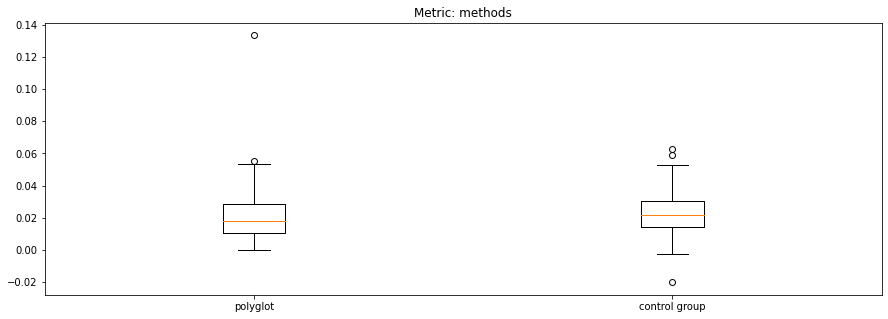

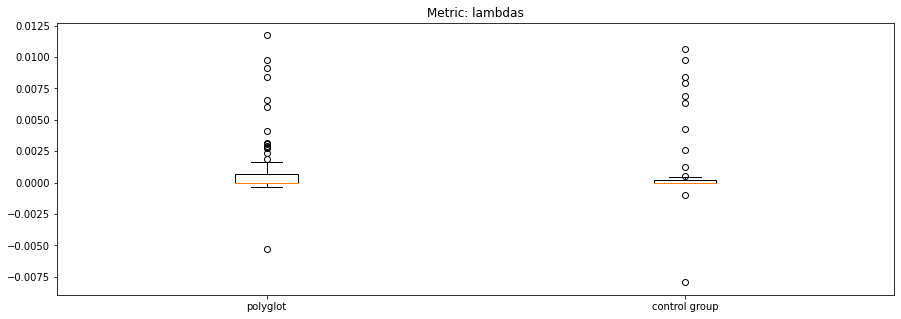

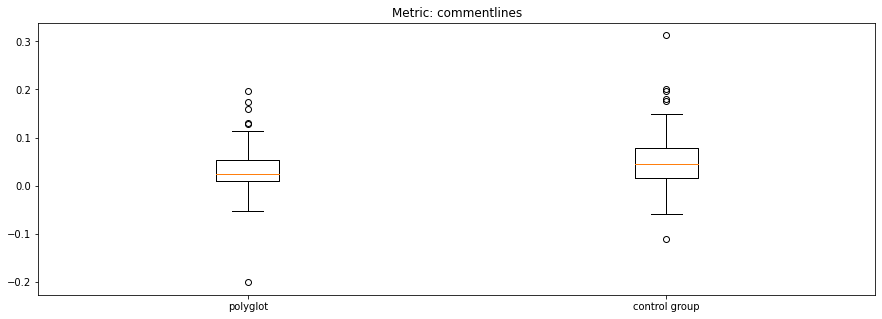

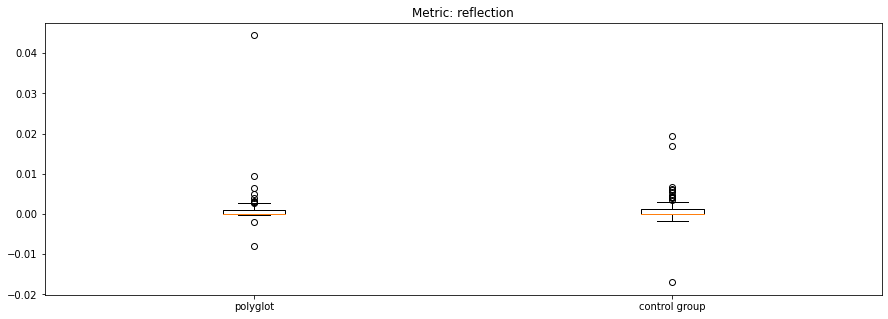

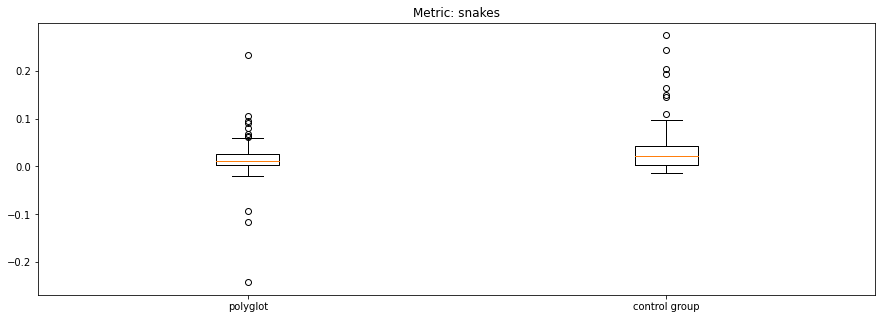

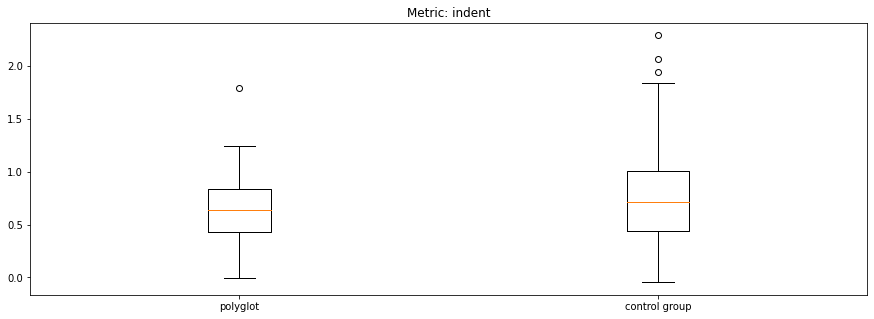

In [28]:
for metric in boxDataPolyglot:
    if metric == 'author_id': continue 
        
    pyplot.figure(figsize=(15, 5))
    pyplot.title('Metric: '+metric)
    pyplot.boxplot([boxDataPolyglot[metric], boxDataControlGroup[metric]], labels=['polyglot', 'control group'])
    pyplot.savefig('figures/boxplot_'+metric+'.png')

# Statistical Testing

Again, a  Mann–Whitney U test is applies. All metrics that were identified as significant before were identified again, most with better certainties (as would be expected with a strict data superset). One outlyer is comment line density, but this is inside uncertainty boundaries.

Interestingly, compared to the first evaluation, snake case density has now been identified as significant. This is not surprising, as the last test already indicated this tendency. However, the next, scaled-up, run will need to confirm this result.  

In [29]:
from scipy.stats import mannwhitneyu

for metric in boxDataPolyglot:
    if metric == 'author_id': continue 
    pvalue = mannwhitneyu(boxDataPolyglot[metric], boxDataControlGroup[metric]).pvalue
    print((metric+': ').ljust(15)+str(pvalue)+'\t '+str(pvalue < 0.05))

loc:           0.03300520224406583	 True
cloc:          0.022058035759941794	 True
filecount:     0.21545100634855147	 False
methods:       0.0917505570894625	 False
lambdas:       0.4067688390652851	 False
commentlines:  0.02077806898728143	 True
reflection:    0.42879115773327764	 False
snakes:        0.029028346082374923	 True
indent:        0.024817833855852296	 True


As the run with the new methodology was successfull both in run time and in data density, the next run can scale up.